In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


In [ ]:
#USING ARIMA TIME SERIES MODEL

ecg_data = pd.read_csv('/content/Time_Series_Data_final.csv')
ecg_data.head(10)

,Time Stamp(hrs:min.millisec,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,0:00.000,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
1,0:00.004,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
2,0:00.008,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
3,0:00.012,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
4,0:00.016,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-63.44,-63.44,-34.16,0.00,87.84
5,0:00.020,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-58.56,-58.56,-29.28,0.00,87.84
6,0:00.024,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-53.68,-53.68,-24.40,0.00,87.84
7,0:00.028,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-48.80,-48.80,-19.52,0.00,87.84
8,0:00.032,29.28,24.40,-4.88,-24.40,14.64,9.76,-43.92,-39.04,-39.04,-4.88,4.88,97.60
9,0:00.036,29.28,19.52,-9.76,-24.40,19.52,4.88,-39.04,-29.28,-29.28,0.00,9.76,97.60


**Data preprocessing**





In [ ]:
ecg_data.rename(columns={'I': 'Lead_1'}, inplace=True)
ecg_data.rename(columns={'II': 'Lead_2'}, inplace=True)
ecg_data.rename(columns={'III': 'Lead_3'}, inplace=True)
ecg_data.rename(columns={'Time Stamp(hrs:min.millisec': 'Time_stamp'}, inplace=True)

ecg_data

,Time_stamp,Lead_1,Lead_2,Lead_3,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,0:00.000,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
1,0:00.004,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
2,0:00.008,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
3,0:00.012,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
4,0:00.016,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-63.44,-63.44,-34.16,0.00,87.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4983,0:19.932,78.08,68.32,-9.76,-73.20,43.92,29.28,-136.64,-156.16,-146.40,-175.68,78.08,117.12
4984,0:19.936,78.08,68.32,-9.76,-73.20,43.92,29.28,-136.64,-156.16,-146.40,-175.68,78.08,117.12
4985,0:19.940,78.08,68.32,-9.76,-73.20,43.92,29.28,-136.64,-156.16,-146.40,-175.68,78.08,117.12
4986,0:19.944,78.08,68.32,-9.76,-73.20,43.92,29.28,-136.64,-156.16,-146.40,-175.68,78.08,117.12


In [ ]:
data = ecg_data['Time_stamp']
df = pd.DataFrame(data)
## error in converting to date time format because of datatype so separate all parts and re-add them

# First, split the column into minutes, seconds, and milliseconds
df[['Minutes', 'Seconds.Milliseconds']] = df['Time_stamp'].str.split(':', expand=True)

# Convert minutes, seconds, and milliseconds columns to integers
df['Minutes'] = df['Minutes'].astype(int)
df['Seconds.Milliseconds'] = pd.to_numeric(df['Seconds.Milliseconds'], errors='coerce')

# Convert the time components to a timedelta
df['Time_Delta'] = pd.to_timedelta(df['Minutes'], unit='m') + pd.to_timedelta(df['Seconds.Milliseconds'], unit='s')

# Add the time delta to a common date
df['Timestamp'] = pd.to_datetime('00:00:00') + df['Time_Delta']

# Drop intermediate columns if not needed
df = df.drop(['Minutes', 'Seconds.Milliseconds', 'Time_Delta'], axis=1)

# Format the timestamp to display only hours, minutes, seconds, and milliseconds
df['Timestamp'] = df['Timestamp'].dt.strftime('%H:%M:%S.%f').str[:-3]


ecg_data['Time_stamp']=df['Timestamp']
ecg_data.head()

,Time_stamp,Lead_1,Lead_2,Lead_3,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,00:00:00.000,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
1,00:00:00.004,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
2,00:00:00.008,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
3,00:00:00.012,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
4,00:00:00.016,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-63.44,-63.44,-34.16,0.00,87.84


In [ ]:
ecg_data.head()

,Time_stamp,Lead_1,Lead_2,Lead_3,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,00:00:00.000,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
1,00:00:00.004,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
2,00:00:00.008,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
3,00:00:00.012,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
4,00:00:00.016,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-63.44,-63.44,-34.16,0.00,87.84


In [ ]:
ecg_data.columns
ecg_data.set_index('Time_stamp', inplace=True)
ecg_data.head(10)

,Lead_1,Lead_2,Lead_3,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
Time_stamp,,,,,,,,,,,,
00:00:00.000,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
00:00:00.004,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
00:00:00.008,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
00:00:00.012,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
00:00:00.016,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-63.44,-63.44,-34.16,0.00,87.84
00:00:00.020,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-58.56,-58.56,-29.28,0.00,87.84
00:00:00.024,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-53.68,-53.68,-24.40,0.00,87.84
00:00:00.028,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-48.80,-48.80,-19.52,0.00,87.84
00:00:00.032,29.28,24.40,-4.88,-24.40,14.64,9.76,-43.92,-39.04,-39.04,-4.88,4.88,97.60


In [ ]:
ecg_data_final=ecg_data
ecg_data_final.head(5)

,Lead_1,Lead_2,Lead_3,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
Time_stamp,,,,,,,,,,,,
00:00:00.000,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
00:00:00.004,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
00:00:00.008,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
00:00:00.012,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84
00:00:00.016,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-63.44,-63.44,-34.16,0.00,87.84


In [ ]:
ecg_data.index[:1000]

Index(['00:00:00.000', '00:00:00.004', '00:00:00.008', '00:00:00.012',
       '00:00:00.016', '00:00:00.020', '00:00:00.024', '00:00:00.028',
       '00:00:00.032', '00:00:00.036',
       ...
       '00:00:03.960', '00:00:03.964', '00:00:03.968', '00:00:03.972',
       '00:00:03.976', '00:00:03.980', '00:00:03.984', '00:00:03.988',
       '00:00:03.992', '00:00:03.996'],
      dtype='object', name='Time_stamp', length=1000)

Transformation(differencing) for trend **identification**

In [ ]:
data=ecg_data['Lead_1']
ecg_data['Diff']=data.diff() #differencing to check the trend of data
print(ecg_data['Diff'])
ecg_data['Diff'].unique()
ecg_data

Time_stamp
00:00:00.000    NaN
00:00:00.004    0.0
00:00:00.008    0.0
00:00:00.012    0.0
00:00:00.016    0.0
               ... 
00:00:19.932    0.0
00:00:19.936    0.0
00:00:19.940    0.0
00:00:19.944    0.0
00:00:19.948    0.0
Name: Diff, Length: 4988, dtype: float64


,Lead_1,Lead_2,Lead_3,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6,Diff
Time_stamp,,,,,,,,,,,,,
00:00:00.000,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84,NaN
00:00:00.004,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84,0.0
00:00:00.008,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84,0.0
00:00:00.012,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84,0.0
00:00:00.016,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-63.44,-63.44,-34.16,0.00,87.84,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:00:19.932,78.08,68.32,-9.76,-73.20,43.92,29.28,-136.64,-156.16,-146.40,-175.68,78.08,117.12,0.0
00:00:19.936,78.08,68.32,-9.76,-73.20,43.92,29.28,-136.64,-156.16,-146.40,-175.68,78.08,117.12,0.0
00:00:19.940,78.08,68.32,-9.76,-73.20,43.92,29.28,-136.64,-156.16,-146.40,-175.68,78.08,117.12,0.0


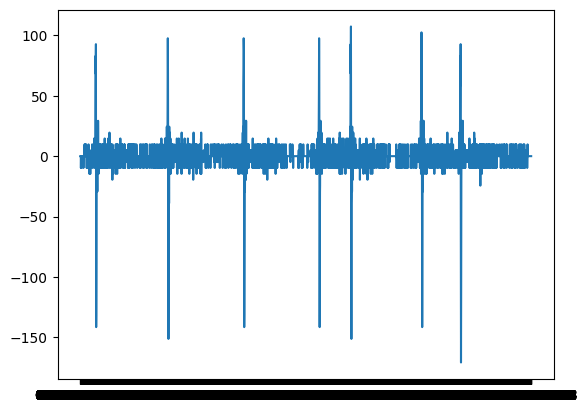

In [ ]:
plt.plot(ecg_data['Diff']) # trend of readings for Lead_1 only since it has been taken as test variable for all tests

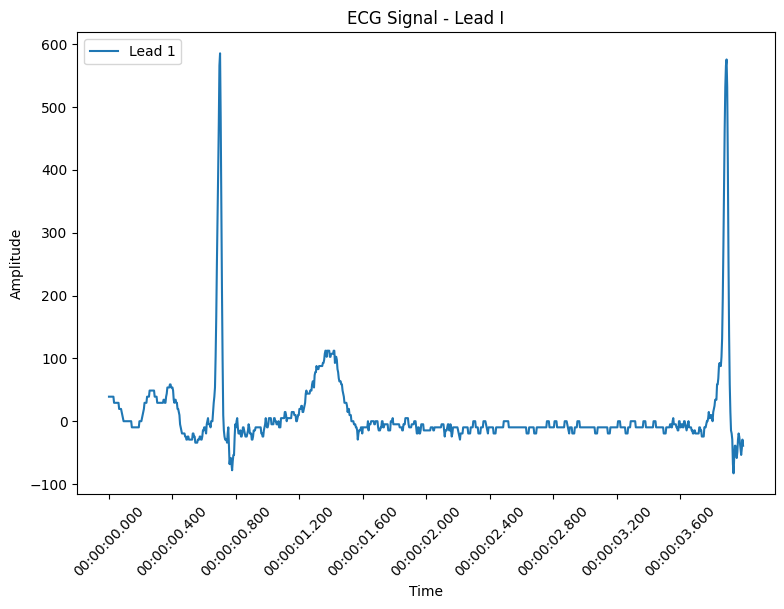

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(ecg_data.index[:1000], ecg_data['Lead_1'].head(1000), label='Lead 1')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('ECG Signal - Lead I')
plt.legend()
x_values = ecg_data.index[:1000]
plt.xticks(range(0, len(x_values), 100), x_values[::100], rotation=45)  # Customize the x-axis ticks

plt.show()

CHECKING FOR STATIONARITY USING ADF TEST

In [ ]:
# Assuming 'ecg_data' is your DataFrame with ECG data, and you want to test 'Lead_I'
result = sm.tsa.adfuller(ecg_data['Lead_1'], autolag='AIC')
# Print the ADF test results
print('ADF Statistic:', result[0])
p='p-value'
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1]>0.05:
  print("Series not stationary")
else:
  print("Series is stationary")

ADF Statistic: -9.557843713075636
p-value: 2.471281874105716e-16
Critical Values: {'1%': -3.431670421982744, '5%': -2.8621234825673536, '10%': -2.5670805886785306}
Series is stationary


P VALUE < 0.05 THEREFORE STATIONARY PROCESS

In [ ]:
ecg_data.columns

Index(['Lead_1', 'Lead_2', 'Lead_3', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3',
       'V4', 'V5', 'V6', 'Diff'],
      dtype='object')

Plotting acf/pacf to get order for the model to be applied on the
 data

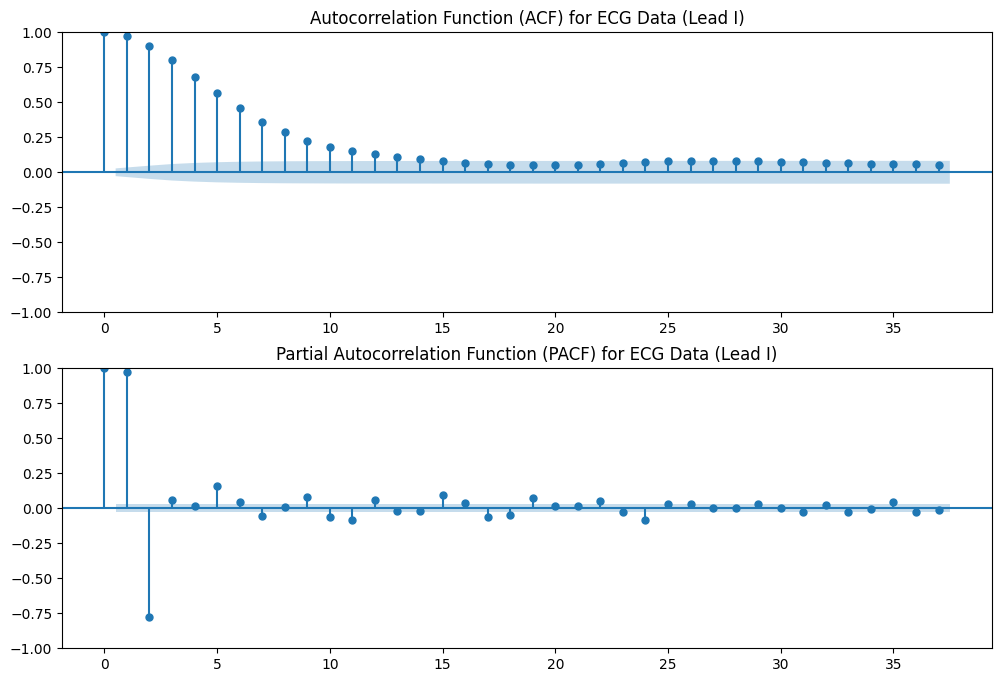

In [ ]:
# taking 'Lead_I' is the column containing ECG data, adjust it if necessary
ecg_data1 = ecg_data['Lead_1']

# Plot ACF and PACF
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(ecg_data1, ax=ax[0], title='Autocorrelation Function (ACF) for ECG Data (Lead I)')
plot_pacf(ecg_data1, ax=ax[1], title='Partial Autocorrelation Function (PACF) for ECG Data (Lead I)')

plt.show()

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.9 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

In [ ]:
ecg_data_final.head(10)

,Lead_1,Lead_2,Lead_3,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6,Diff
Time_stamp,,,,,,,,,,,,,
00:00:00.000,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84,NaN
00:00:00.004,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84,0.00
00:00:00.008,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84,0.00
00:00:00.012,39.04,19.52,-19.52,-29.28,29.28,0.00,-58.56,-78.08,-68.32,-48.80,-9.76,87.84,0.00
00:00:00.016,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-63.44,-63.44,-34.16,0.00,87.84,0.00
00:00:00.020,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-58.56,-58.56,-29.28,0.00,87.84,0.00
00:00:00.024,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-53.68,-53.68,-24.40,0.00,87.84,0.00
00:00:00.028,39.04,29.28,-9.76,-34.16,24.40,9.76,-58.56,-48.80,-48.80,-19.52,0.00,87.84,0.00
00:00:00.032,29.28,24.40,-4.88,-24.40,14.64,9.76,-43.92,-39.04,-39.04,-4.88,4.88,97.60,-9.76


In [ ]:
ecg_data_final['Lead_1'].head(10)

Time_stamp
00:00:00.000    39.04
00:00:00.004    39.04
00:00:00.008    39.04
00:00:00.012    39.04
00:00:00.016    39.04
00:00:00.020    39.04
00:00:00.024    39.04
00:00:00.028    39.04
00:00:00.032    29.28
00:00:00.036    29.28
Name: Lead_1, dtype: float64

PMDARIMA LIBRARY USED TO CHECK LOWEST **AIC** TO GET THE FOLLOWING P Q D FOR TIME SERIES MODEL

In [ ]:
# List of Lead columns
lead_columns = ['Lead_1', 'Lead_2', 'Lead_3', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Iterate through the lead columns and fit the ARIMA model
for lead in lead_columns:
    lead_data = ecg_data[lead]
    print(f"Fitting ARIMA for {lead}...")

    stepwise_fit = auto_arima(lead_data, start_p=1, start_q=1, max_p=2, max_q=2, m=12,
                              start_P=0, seasonal=True, d=1, D=1, trace=True,
                              error_action='ignore', suppress_warnings=True, stepwise=True, information_criteria='aic')

    print(stepwise_fit.summary())

Fitting ARIMA for Lead_1...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=29.83 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=43771.159, Time=0.59 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=37625.475, Time=2.36 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=15.45 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=39250.124, Time=0.68 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=36974.059, Time=5.59 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=44.70 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=17.04 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=41271.919, Time=4.46 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=36878.579, Time=8.86 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=37559.061, Time=5.25 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=57.25 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=27.05 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=56.19 sec
 ARIMA(1,1,1

KeyboardInterrupt: ignored

Taking an electrode from user to check anomaly in that particular ecg data

In [ ]:
print("Electrode to check -- Lead_1 : Lead_2 : Lead_3 : aVR : aVL : aVF : V1 : V2 : V3 : V4 : V5 : V6")

var = ['Lead_1' , 'Lead_2','Lead_3' , 'aVR','aVL' ,'aVF' ,'V1' ,'V2' ,'V3' , 'V4', 'V5', 'V6']

user_input_correct = False

while not user_input_correct:
    lead_name = input("Enter your choice  : ")
    if lead_name in var:
        user_input_correct = True
        print()
    else:
        print(f"Invalid choice. Please enter a valid ")


  # Replace with the lead you want to analyze
lead_data = ecg_data[lead_name]
p = 2  # AR order
d = 1  # Differencing order
q = 0 # MA order

model = sm.tsa.ARIMA(lead_data, order=(p, d, q))
results = model.fit()

# Get model residuals
residuals = results.resid

# Calculate the standard deviation of residuals
residual_std = np.std(residuals)

# Define a threshold for anomaly detection (e.g., 3 times the standard deviation)
threshold = 3 * residual_std
threshold

# Detect anomalies based on residuals
anomalies = np.abs(residuals) > threshold

plt.figure(figsize=(12, 6))
plt.plot(ecg_data.index, lead_data, label=f'{lead_name}', alpha=0.8, zorder=2)  # Increase the zorder for the line plot
plt.scatter(ecg_data.index[anomalies], lead_data[anomalies], color='red', label=f'{lead_name} (Anomaly)', s=90 , zorder=2)  # Increase the zorder for the red dots

# Add red lines at the locations of anomalies
plt.vlines(ecg_data.index[anomalies], ymin=lead_data.min(), ymax=lead_data.max(), color='red', linestyle='dashed', linewidth=2, label='Anomaly Location', zorder=3)  # Increase the zorder for the red lines

plt.title(f'ECG Data ({lead_name}) with Anomalies Detected (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Set the background color to white or any other suitable color
plt.gca().set_facecolor('white')

plt.show()

DEFINING A FUNCTION TO CROSS CHECK ANOMALIES TREND WITH THE MODEL

In [ ]:
def detect_anomalies(ecg_data , threshold=3):
    z_scores = np.abs(stats.zscore(ecg_data ))
    anomaly_indices = np.where(z_scores > threshold)
    return anomaly_indices

# Set a Z-Score threshold for anomaly detection
z_score_threshold = 3

# Detect anomalies for each lead
anomalies = detect_anomalies(ecg_data , z_score_threshold)

# Create a new ecg_data Frame to mark anomalies
anomaly_df = ecg_data .copy()
anomaly_df.iloc[anomalies] = np.nan
print(anomaly_df)

In [ ]:
plt.figure(figsize=(12, 6))
for lead in anomaly_df.columns:
    plt.plot(anomaly_df.index, anomaly_df[lead], label=lead)

plt.title('ECG Data with Anomalies Marked')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()